In [1]:
import sys
sys.path.append("../")

In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import torch
from tqdm import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from models.likelihoods import log_like_np
from models.nptf_model import NPRegression
from utils.templates import get_NFW2_template
from utils.psf_correction import PSFCorrection
from utils import create_mask as cm
from models.psf import KingPSF

In [189]:
from NPTFit import npll
from NPTFit import pll

In [681]:
import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [5]:
nside = 128

# Get mask of central pixel for nside=1
hp_mask_nside1 = cm.make_mask_total(nside=1, band_mask=True, band_mask_range=0, mask_ring=True, inner=0, outer=25)

# Get mask corresponding to nside=128
mask_sim = hp.ud_grade(hp_mask_nside1, nside)

npix = hp.nside2npix(nside)
pixarea = hp.nside2pixarea(nside, degrees=False)
pixarea_deg = hp.nside2pixarea(nside, degrees=True)

In [568]:
# Load templates
temp_gce = np.load("../data/fermi_data/template_gce.npy") # get_NFW2_template(gamma=1.2)
temp_dif = np.load("../data/fermi_data/template_dif.npy")
temp_psc = np.load("../data/fermi_data/template_psc.npy")
temp_iso = np.load("../data/fermi_data/template_iso.npy")
temp_dsk = np.load("../data/fermi_data/template_dsk.npy")
temp_bub = np.load("../data/fermi_data/template_bub.npy")

temp_mO_pibrem = np.load('../data/fermi_data/ModelO_r25_q1_pibrem.npy')
temp_mO_ics = np.load('../data/fermi_data/ModelO_r25_q1_ics.npy')

temp_mA_pibrem = hp.ud_grade(np.load('../data/modelA/modelA_brempi0.npy'), nside_out=128, power=-2)
temp_mA_ics = hp.ud_grade(np.load('../data/modelA/modelA_ics.npy'), nside_out=128, power=-2)

fermi_exp = np.load("../data/fermi_data/fermidata_exposure.npy")
fermi_data = np.load("../data/fermi_data/fermidata_counts.npy")

ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")
ps_mask = np.load("../data/fermi_data/fermidata_pscmask.npy") == 1
roi_mask = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=25, custom_mask=ps_mask)

In [362]:
# Define parameters that specify the Fermi-LAT PSF at 2 GeV
fcore = 0.748988248179
score = 0.428653790656
gcore = 7.82363229341
stail = 0.715962650769
gtail = 3.61883748683
spe = 0.00456544262478

# Define the full PSF in terms of two King functions
def king_fn(x, sigma, gamma):
    return 1./(2.*np.pi*sigma**2.)*(1.-1./gamma)*(1.+(x**2./(2.*gamma*sigma**2.)))**(-gamma)

def Fermi_PSF(r):
    return fcore*king_fn(r/spe,score,gcore) + (1-fcore)*king_fn(r/spe,stail,gtail)

# Modify the relevant parameters in pc_inst and then make or load the PSF
pc_inst = PSFCorrection(delay_compute=True)
pc_inst.psf_r_func = lambda r: Fermi_PSF(r)
pc_inst.sample_psf_max = 10.*spe*(score+stail)/2.
pc_inst.psf_samples = 10000
pc_inst.psf_tag = 'Fermi_PSF_2GeV'
pc_inst.make_or_load_psf_corr()

# Extract f_ary and df_rho_div_f_ary as usual
f_ary = pc_inst.f_ary
df_rho_div_f_ary = pc_inst.df_rho_div_f_ary

Loading the psf correction from: /Users/smsharma/PycharmProjects/sbi-fermi/notebooks/psf_dir/Fermi_PSF_2GeV.npy


In [365]:
import dynesty
from multiprocessing import Pool
from dynesty import DynamicNestedSampler, NestedSampler
from dynesty.utils import resample_equal

from models.scd import dnds


class NPRegression:
    def __init__(self, temps_poiss, temps_ps, priors_poiss, data, priors_ps=None, f_ary=[1.], df_rho_div_f_ary=[1.], roi_mask=None, param_log=None, transform_prior_on_s=True):
        
        self.transform_prior_on_s = transform_prior_on_s
        
        self.temps_poiss= temps_poiss
        self.temps_ps = temps_ps
        self.priors_poiss = priors_poiss
        self.priors_ps = priors_ps
        self.data = data.astype(np.int32)
        self.roi_mask = roi_mask
        
        if self.priors_ps is not None:
            self.priors = np.concatenate([np.transpose(self.priors_poiss), np.transpose(self.priors_ps)])
        else:
            self.priors = np.transpose(self.priors_poiss)
            
        self.priors_lo = self.priors[:, 0]
        self.priors_interval = self.priors[:, 1] - self.priors[:, 0]
 
        self.f_ary = f_ary
        self.df_rho_div_f_ary = df_rho_div_f_ary
        
        self.n_poiss = len(temps_poiss)
        self.n_ps = len(temps_ps)
        self.n_ps_params = 6
        self.n_params = self.n_poiss + self.n_ps_params * self.n_ps
        
        self.param_log = param_log

        if self.roi_mask is not None:
            self.temps_poiss = np.array([temp[~self.roi_mask] for temp in self.temps_poiss])
            self.temps_ps = np.array([temp[~self.roi_mask] for temp in self.temps_ps])
            self.data = np.array(self.data[~self.roi_mask])
                
    def loglike(self, theta):
        
        theta[self.param_log] = 10 ** theta[self.param_log]
        theta_poiss = theta[:self.n_poiss]

        theta_ps = np.array(np.split(theta[self.n_poiss:], self.n_ps))
            
        if self.transform_prior_on_s:

            theta_poiss[0] /= np.mean(self.temps_poiss[0])

            for i_ps in torch.arange(self.n_ps):

                s_ary = torch.logspace(-2, 2, 100)
                s_exp_temp = theta_ps[i_ps][0]
                theta_ps[i_ps][0] = 1.
                dnds_ary_temp = dnds(s_ary, theta_ps[i_ps])
                s_exp = np.mean(self.temps_ps[i_ps]) * np.trapz(s_ary * dnds_ary_temp, s_ary)

                theta_ps[i_ps][0] = s_exp_temp / s_exp
        
        pt_sum_compressed = np.sum(self.temps_poiss * theta_poiss[:, np.newaxis], axis=0)
        
        return npll.log_like(pt_sum_compressed, theta_ps, self.f_ary, self.df_rho_div_f_ary, self.temps_ps, self.data)

    def prior_cube(self, u, ndim=1, nparams=1):

        u *= self.priors_interval 
        u += self.priors_lo
        
        return u

    def run_dynesty(self, nlive=400, n_cpus=4):

        n_dim = self.n_params

        with Pool(processes=n_cpus) as pool:

            sampler = NestedSampler(self.loglike, self.prior_cube, n_dim, pool=pool, queue_size=n_cpus, nlive=nlive)
            sampler.run_nested(dlogz=1.)

        # Draw posterior samples
        weights = np.exp(sampler.results['logwt'] - sampler.results['logz'][-1])
        samples_weighted = resample_equal(sampler.results.samples, weights)

        return sampler.results.samples, samples_weighted

In [246]:
temps_poiss = [temp_gce, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]
priors_poiss = [[0., 0.001, 0.001, 0.001, 6., 1.], 
               [3.5, 1.5, 1.5, 1.5, 12., 6.]]

temps_ps = [temp_gce / (fermi_exp / np.mean(fermi_exp)), temp_dsk / (fermi_exp / np.mean(fermi_exp))]
priors_ps = [[0., 10.0, 1.1, -10.0, 5.0, 0.1, 0., 10.0, 1.1, -10.0, 5.0, 0.1], 
            [3.5, 20.0, 1.99, 1.99, 50.0, 4.99, 3.5, 20.0, 1.99, 1.99, 50.0, 4.99]]

param_log = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0 ,0 ,0 ,0, 0])
param_log = param_log.astype(np.bool)

In [296]:
temps_poiss = [temp_gce, temp_iso, temp_bub, temp_psc, temp_dif]
temps_ps = [temp_gce / (fermi_exp / np.mean(fermi_exp)), temp_dsk / (fermi_exp / np.mean(fermi_exp))]
roi_mask = roi_mask

# gce, dsk PS priors
priors_ps = [[0., 10.0, 1.1, -10.0, 5.0, 0.1, 0., 10.0, 1.1, -10.0, 5.0, 0.1], 
            [3.5, 20.0, 1.99, 1.99, 50.0, 4.99, 3.5, 20.0, 1.99, 1.99, 50.0, 4.99]]

priors_poiss = [[0., 0.001, 0.001, 0.001, 10.], 
               [3.5, 1.5, 1.5, 1.5, 20.]]

param_log = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0 ,0 ,0 ,0])
param_log = param_log.astype(np.bool)

In [366]:
temps_poiss = [temp_gce, temp_iso, temp_bub, temp_psc, temp_dif]
temps_ps = [temp_gce / (fermi_exp / np.mean(fermi_exp)), temp_dsk / (fermi_exp / np.mean(fermi_exp))]
roi_mask = roi_mask

# gce, dsk PS priors
priors_ps = [[-6, 10.0, 1.1, -10.0, 5.0, 0.1, -6, 10.0, 1.1, -10.0, 5.0, 0.1], 
            [0, 20.0, 1.99, 1.99, 50.0, 4.99, 0, 20.0, 1.99, 1.99, 50.0, 4.99]]

priors_poiss = [[-2., 0.001, 0.001, 0.001, 10.], 
               [1., 1.5, 1.5, 1.5, 20.]]

param_log = np.array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0 ,0 ,0 ,0 ,0])
param_log = param_log.astype(np.bool)

In [367]:
npr = NPRegression(temps_poiss, temps_ps, priors_poiss, fermi_data, priors_ps, f_ary, df_rho_div_f_ary, roi_mask=roi_mask, param_log=param_log)

In [ ]:
### _, samples_weighted = npr.run_dynesty()

In [654]:
def dnds(s, sample):
    """ dN/dS values for NPT comp associated with a chain sample
    """

    samples_reduced = sample

    nbreak = int((len(samples_reduced) - 2)/2.)

    # Get APS (float) and slopes/breaks (arrays)
    a_ps, n_ary, sb_ary = samples_reduced[0], samples_reduced[1:nbreak+2], \
        samples_reduced[nbreak+2:]

    # Determine where the s values fall with respect to the breaks
    where_vecs = [[] for _ in range(nbreak+1)]
    where_vecs[0] = np.where(s >= sb_ary[0])[0]
    for i in range(1, nbreak):
        where_vecs[i] = np.where((s >= sb_ary[i]) & (s < sb_ary[i-1]))[0]
    where_vecs[-1] = np.where(s < sb_ary[-1])[0]

    # Calculate dnds values for a broken power law with arbitrary breaks
    dnds = np.zeros(len(s))
    dnds[where_vecs[0]] = a_ps*(s[where_vecs[0]]/sb_ary[0])**(-n_ary[0])
    dnds[where_vecs[1]] = a_ps*(s[where_vecs[1]]/sb_ary[0])**(-n_ary[1])

    for i in range(2, nbreak+1):
        dnds[where_vecs[i]] = \
            a_ps*np.prod([(sb_ary[j+1]/sb_ary[j])**(-n_ary[j+1])
                          for j in range(0, i-1)]) * \
            (s[where_vecs[i]]/sb_ary[i-1])**(-n_ary[i])

    return dnds


In [717]:
area_mask = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=25)
div = np.mean(fermi_data[~area_mask])

In [722]:
samples_weighted = np.load("/Users/smsharma/Desktop/runs_25_ModelO_0_0.8_samples.npz")["samples_thinned_flattened"]
samples = copy.deepcopy(samples_weighted)

idx = 6

s_ary = np.logspace(-2, 2, 100)
samps_ps = [np.trapz(s_ary * dnds(s_ary, samp), s_ary) * np.mean(temp_gce[~area_mask]) / div * 100 for samp in samples[:, idx:idx+6]]
samps_dsk = [np.trapz(s_ary * dnds(s_ary, samp), s_ary) * np.mean(temp_dsk[~area_mask]) / div * 100 for samp in samples[:, idx+6:]]
samps_dm = (samples[:, 0] * np.mean(npr.temps_poiss[0]) / np.mean(fermi_data[~area_mask]) * 100)

In [738]:
samples_weighted = np.load("/Users/smsharma/Desktop/runs_25_ModelO_1_0.8_samples.npz")["samples_thinned_flattened"]
samples = copy.deepcopy(samples_weighted)

idx = 6

samps_dm = samples[:, 0] / div * 100
samps_ps = samples[:, idx] / div * 100
samps_dsk = samples[:, idx+6] / div * 100

Removed no burn in


(0.0, 15.0)

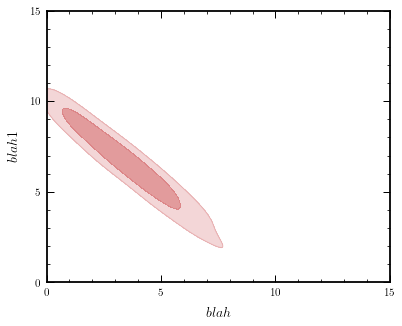

<Figure size 432x324 with 0 Axes>

In [739]:
from getdist import plots, MCSamples
import getdist

samps = np.transpose(np.array([samps_dm, samps_ps]))

fig, ax = plt.subplots()

g = plots.get_single_plotter()
samps_inst = MCSamples(samples=samps, names = ['blah','blah1'], labels = ['blah','blah1'])
g.plot_2d(samps_inst, 'blah', 'blah1', filled=True, ax=ax, alphas=[0.5], colors=[cols_default[0]])
ax.set_xlim(0, 15)
ax.set_ylim(0, 15)